# Visualization model and predictions

In [1]:
library(magrittr)

## Plot model coefficients

In [2]:
coef_df = readr::read_tsv('./model/coefficient.tsv') %>%
  dplyr::arrange(desc(coef))

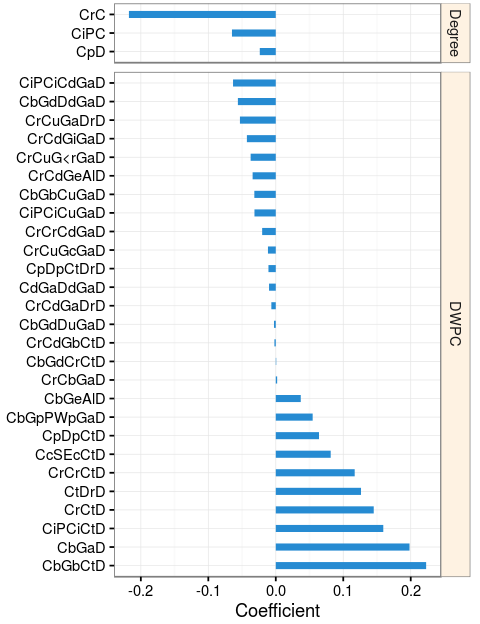

In [3]:
options(repr.plot.width=4, repr.plot.height=5.2)
gg_coef = coef_df %>%
  dplyr::filter(! (feature %in% c('prior_logit', 'intercept'))) %>%
  tidyr::separate(feature, c('feature_type', 'metapath'), '_') %>%
  dplyr::mutate(feature_type = c(degree = 'Degree', dwpc = 'DWPC')[feature_type])  %>%
  dplyr::mutate(metapath = factor(metapath, levels=metapath)) %>%
  dplyr::filter(coef != 0) %>%
  ggplot2::ggplot(ggplot2::aes(coef, y=metapath, xmin=0, xmax=coef)) +
  ggplot2::facet_grid(feature_type ~ ., scales = 'free_y', space = 'free_y') +
  ggplot2::geom_errorbarh(stat='identity', size=2, height=0, color = '#268BD2') +
  ggplot2::xlab('Coefficient') + ggplot2::ylab(NULL) +
  hetior::theme_dhimmel(base_size = 11)

gg_coef

## Prediction Distributions of Various Gold Standards

In [4]:
prob_df = readr::read_tsv('./predictions/probabilities.tsv')

In [85]:
context_map = c(
  DM='Disease Modifying',        
  status_drugcentral='DrugCentral',
  status_trials='Clinical Trial',
  SYM='Symptomatic'
)

context_colors = c(
  DM='#00693E',        
  status_drugcentral='#B31B1B',
  status_trials='#EE7F2D',
  SYM='#01256E'
)

In [7]:
grouped_df = prob_df %>%
  dplyr::mutate(DM = category %in% 'DM', SYM = category %in% 'SYM') %>%
  dplyr::rename(net_status=status) %>%
  tidyr::gather(context, status, DM, SYM, status_trials, status_drugcentral) %>%
  dplyr::filter(context == 'DM' | net_status == 0) %>%
  dplyr::filter(!is.na(status)) %>%
  dplyr::group_by(context) %>%
  dplyr::mutate(predictile = dplyr::cume_dist(prediction)) %>%
  dplyr::mutate(priortile = dplyr::cume_dist(dplyr::row_number(prior_prob)))

vtms <- list()
auroc_df = grouped_df %>%
  dplyr::do({
    vtm = hetior::calc_vtms(y_true = .$status, y_pred = .$prediction)
    context = .$context %>% unique
    vtm$roc_df$context = context
    vtm$prc_df = hetior::prune_prc(vtm$threshold_df)
    vtm$prc_df$context = context
    vtms[[context]] <<- vtm
    dplyr::data_frame(auroc = vtm$auroc, auprc = vtm$auprc, n_neg = sum(.$status == 0), n_pos = sum(.$status == 1))
  }) %>%
  dplyr::mutate(context_fmt = context_map[context]) %>%
  dplyr::slice(match(names(context_map), context)) %>%
  dplyr::mutate(npos_fmt = sprintf("%s (+%s, −%s)", context_fmt, format(n_pos, big.mark=','), format(n_neg, big.mark=','))) %>%
  dplyr::mutate(auroc_fmt = sprintf("%1.1f%%", 100 * auroc)) %>%
  dplyr::mutate(auprc_fmt = sprintf("%s (%1.1f%%)", context_fmt, 100 * auprc))

context_npos_map = auroc_df %$% setNames(npos_fmt, context)
context_roc_map = auroc_df %$% setNames(auroc_fmt, context)
context_prc_map = auroc_df %$% setNames(auprc_fmt, context)

auroc_df

perf_1d_df = grouped_df %>%
  dplyr::ungroup() %>%
  dplyr::filter(status == 1) %>%
  dplyr::select(compound_id:disease_name, context, status, predictile, priortile)
perf_1d_df %>% head(2)

,context,auroc,auprc,n_neg,n_pos,context_fmt,npos_fmt,auroc_fmt,auprc_fmt
1,DM,0.974478,0.381718,208413,755,Disease Modifying,"Disease Modifying (+755, −208,413)",97.4%,Disease Modifying (38.2%)
2,status_drugcentral,0.8550991,0.05563322,207572,208,DrugCentral,"DrugCentral (+208, −207,572)",85.5%,DrugCentral (5.6%)
3,status_trials,0.6997335,0.09291836,202186,5594,Clinical Trial,"Clinical Trial (+5,594, −202,186)",70.0%,Clinical Trial (9.3%)
4,SYM,0.702446,0.00546723,208023,390,Symptomatic,"Symptomatic (+390, −208,023)",70.2%,Symptomatic (0.5%)


,compound_id,compound_name,disease_id,disease_name,context,status,predictile,priortile
1,DB00843,Donepezil,DOID:10652,Alzheimer's disease,DM,1,0.97284,0.892278
2,DB00674,Galantamine,DOID:10652,Alzheimer's disease,DM,1,0.9834105,0.892431


In [86]:
roc_df = dplyr::rbind_all(lapply(vtms, `[[`, 'roc_df'))
prc_df = dplyr::rbind_all(lapply(vtms, `[[`, 'prc_df'))

In [119]:
roc_breaks = seq(0, 1, 0.2)

gg_roc = roc_df %>% 
  ggplot2::ggplot(ggplot2::aes(fpr, recall, color=context)) +
  ggplot2::geom_segment(x=0, xend=1, y=0, yend=1, color='grey', size=0.5) +
  ggplot2::geom_line(alpha=0.6, size=1) +
  hetior::theme_dhimmel() +
  ggplot2::xlab('False Positive Rate') + ggplot2::ylab('Recall') +
  ggplot2::coord_fixed() +
  ggplot2::scale_x_continuous(breaks=roc_breaks, expand=c(0.03, 0), labels = scales::percent) + 
  ggplot2::scale_y_continuous(breaks=roc_breaks, expand=c(0.03, 0), labels = scales::percent) +
  ggplot2::scale_color_manual(values = context_colors, labels=context_roc_map, guide = ggplot2::guide_legend(title = NULL)) +
  ggplot2::theme(
    legend.justification=c(1, 0), legend.position=c(1, -0.04),
    legend.background=ggplot2::element_blank(), legend.key=ggplot2::element_blank(),
    plot.margin = grid::unit(c(2, 7.5, 2, 2), 'points'))

In [120]:
gg_prc = prc_df %>% 
  ggplot2::ggplot(ggplot2::aes(recall, precision, color=context)) +
  ggplot2::geom_line(alpha=0.6, size=1) +
  hetior::theme_dhimmel() +
  ggplot2::xlab('Recall') + ggplot2::ylab('Precision') +
  ggplot2::scale_x_continuous(breaks=roc_breaks, expand=c(0.03, 0), labels = scales::percent) + 
  ggplot2::scale_y_continuous(breaks=roc_breaks, expand=c(0.03, 0), limits=c(0, 1), labels = scales::percent) +
  ggplot2::theme(
    legend.justification=c(1, 1), legend.position=c(1, 1.05),
    legend.background=ggplot2::element_blank(), legend.key=ggplot2::element_blank()) +
  ggplot2::scale_color_manual(values = context_colors, labels=context_prc_map, guide = ggplot2::guide_legend(title = NULL))

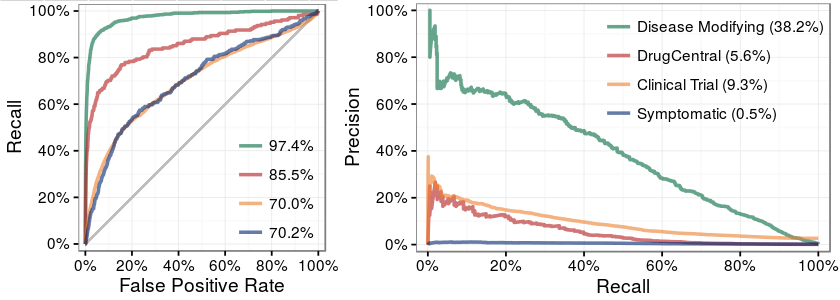

In [126]:
options(repr.plot.width=7, repr.plot.height=2.5)
gg_curve = gridExtra::arrangeGrob(gg_roc, gg_prc, nrow=1, widths=c(1.345, 2))
plot(gg_curve)

In [127]:
options(repr.plot.width=7, repr.plot.height=2.25)
gg_pos_dist = perf_1d_df %>%
  ggplot2::ggplot(ggplot2::aes(context, predictile, fill=context, color=context)) +
  ggplot2::stat_ydensity(
    bw=0.03, draw_quantiles=c(0.25, 0.5, 0.75), # fill='#ffa500', color='#b27300',
    kernel='gaussian', scale='width', alpha = 0.6, size=0.6) +
  hetior::theme_dhimmel() +
  ggplot2::coord_flip() +
  ggplot2::scale_x_discrete(labels=context_npos_map, limits=rev(names(context_map))) +
  ggplot2::scale_y_continuous(breaks = seq(0, 1, 0.1), labels = scales::percent, expand=c(0, 0.018)) +
  ggplot2::ylab('Prediction Percentile Rank') + ggplot2::xlab(NULL) +
  ggplot2::scale_fill_manual(values = context_colors, guide = F) +
  ggplot2::scale_color_manual(values = context_colors, guide = F)

gg_pos_dist = cowplot::switch_axis_position(gg_pos_dist, axis = 'x')

In [130]:
gg_perf = gridExtra::arrangeGrob(gg_pos_dist, gg_curve, ncol=1, heights = c(2.25, 2.5))
gg_perf %>% ggplot2::ggsave(filename = 'figure/performance.pdf', device=cairo_pdf, width=7, height=4.75)
gg_perf %>% ggplot2::ggsave(filename = 'figure/performance.png', width=7, height=4.75, dpi = 300)

In [97]:
alpha_map = c(DM = 0.25, SYM = 0.3, NOT = 0.4, status_drugcentral = 0.35, status_trials = 0.025)

options(repr.plot.width=6, repr.plot.height=3)
gg_gel = perf_1d_df %>%
  ggplot2::ggplot(ggplot2::aes(predictile, context)) +
  ggplot2::geom_point(ggplot2::aes(alpha=context), pch='|', size=7, color = 'white') +
  ggplot2::scale_alpha_manual(values = alpha_map, guide=F) +
  hetior::theme_dhimmel() +
  ggplot2::theme_classic() +
  ggplot2::theme(panel.background = ggplot2::element_rect(fill = 'black')) +
  ggplot2::xlab('Prediction Percentile Rank') + ggplot2::ylab(NULL) +
  ggplot2::scale_y_discrete(labels=context_npos_map, limits=rev(names(context_map)))
gg_gel %>% ggplot2::ggsave(filename = 'figure/performance-gel.pdf', device=cairo_pdf, width=7, height=2.5)

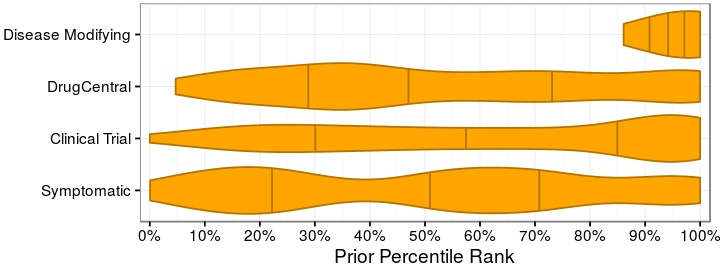

In [99]:
options(repr.plot.width=6, repr.plot.height=2.25)
gg_prior_perf = perf_1d_df %>%
  ggplot2::ggplot(ggplot2::aes(context, priortile)) +
  ggplot2::stat_ydensity(
    bw=0.09, fill='#ffa500', color='#b27300', draw_quantiles=c(0.25, 0.5, 0.75),
    kernel='gaussian', scale='width') +
  hetior::theme_dhimmel() +
  ggplot2::coord_flip() +
  ggplot2::scale_x_discrete(labels=context_map, limits=rev(names(context_map))) +
  ggplot2::scale_y_continuous(breaks = seq(0, 1, 0.1), labels = scales::percent, expand=c(0, 0.018)) +
  ggplot2::ylab('Prior Percentile Rank') + ggplot2::xlab(NULL)

gg_prior_perf

## Disease-specific perf

In [ ]:
get_performance = function(df) {
  vtm = df %$% hetior::calc_vtms(y_true = status, y_pred = prediction, is_prob = T)
  dplyr::data_frame(
    n_positives=sum(df$status),
    auroc=vtm$auroc, 
    auprc=vtm$auprc,
    tjur=vtm$tjur
  ) %>% return
}

In [ ]:
prob_df %>%
  dplyr::group_by(disease_id, disease_name) %>%
  dplyr::do(get_performance(.)) %>%
  dplyr::filter(n_positives > 10)